**Warning:** you will need to do a `pip install tabgan` to help get this notebook to work.

See this [GitHub repo](https://github.com/Diyago/GAN-for-tabular-data).

In [1]:
cd ../

/Users/tombutler/Documents/ai-hackathon


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from tabgan.sampler import OriginalGenerator, GANGenerator

import seaborn as sns
import matplotlib.pyplot as plt

from data.processed.pre_process_titanic import pre_process_df

%load_ext lab_black

### Parameters

In [21]:
TRAIN_DATA_PATH = "data/raw/train.csv"
TEST_DATA_PATH = "data/raw/test.csv"
NUM_COLUMNS = ["Fare", "Age"]
LABEL = "Survived"

COLUMNS = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

In [4]:
# CAT_COLUMNS = [f"embarked_{c}" for c in enc.categories_[0]]
# COLUMNS = data.columns.tolist() + CAT_COLUMNS

### 1. Load in the real data and prepare it

In [22]:
# Load the Titanic dataset
train = pre_process_df(TRAIN_DATA_PATH)[COLUMNS]
target = pd.read_csv(TRAIN_DATA_PATH)[[LABEL]]
test = pre_process_df(TEST_DATA_PATH)[COLUMNS]

### 2. Visualise the data

See what the seaborn pair-plot can show for insight into the numeric feature distributions.

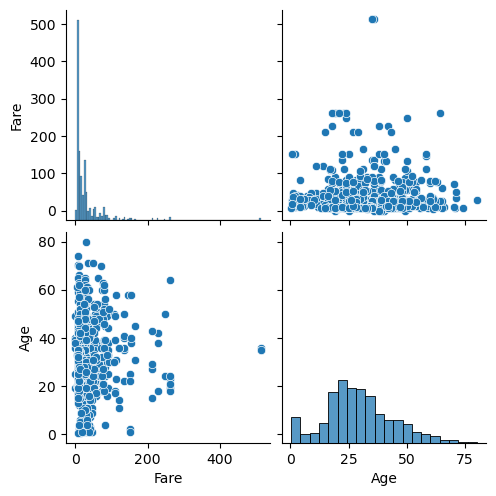

In [23]:
sns.pairplot(train[NUM_COLUMNS])
plt.show()

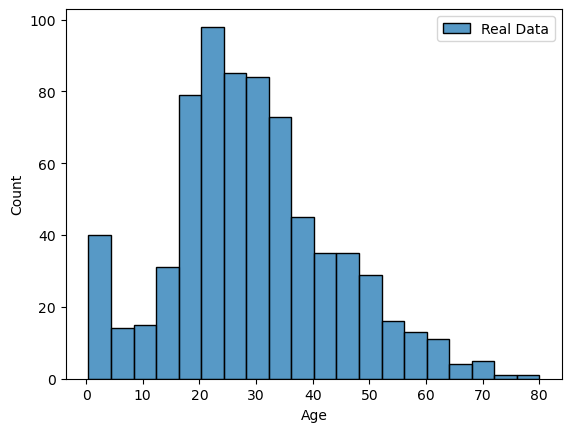

In [24]:
sns.histplot(train["Age"], label="Real Data")
plt.legend()
plt.show()

### 3. tabgan application

In [26]:
# Impute missing values
imputer = SimpleImputer(strategy="median")
train = pd.DataFrame(imputer.fit_transform(train), columns=COLUMNS)
test = pd.DataFrame(imputer.fit_transform(test), columns=COLUMNS)

In [27]:
# example with all params defined
fake_train, fake_target = GANGenerator(
    gen_x_times=100,
    cat_cols=["Pclass", "Sex", "SibSp", "Parch", "Embarked"],
    bot_filter_quantile=0.001,
    top_filter_quantile=0.999,
    is_post_process=True,
    adversarial_model_params={
        "metrics": "AUC",
        "max_depth": 2,
        "max_bin": 100,
        "learning_rate": 0.02,
        "random_state": 42,
        "n_estimators": 500,
    },
    pregeneration_frac=2,
    only_generated_data=False,
    gan_params={
        "batch_size": 500,
        "patience": 25,
        "epochs": 500,
    },
).generate_data_pipe(
    train, target, test, deep_copy=True, only_adversarial=False, use_adversarial=True
)

Training CTGAN, epochs::  40%|█████████████████████████████████▍                                                  | 199/500 [00:12<00:19, 15.76it/s]
/Users/tombutler/miniforge3/envs/jupyter-lab/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/tombutler/miniforge3/envs/jupyter-lab/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/tombutler/miniforge3/envs/jupyter-lab/lib/python3.10/site-packages/lightgbm/ba

### Comparing the real and fake data distributions

In [28]:
real = train.copy()
fake = fake_train.copy()

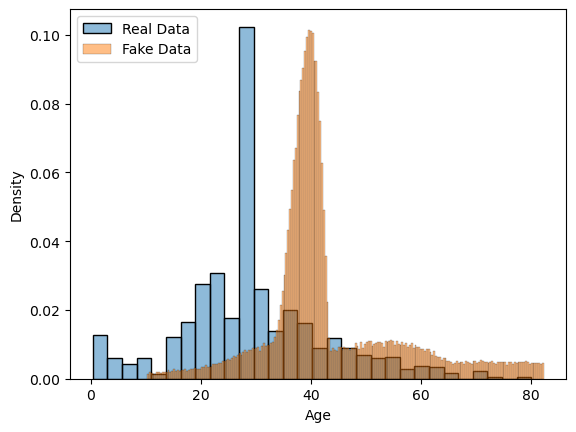

In [29]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

feature = "Age"

sns.histplot(real[feature], label="Real Data", alpha=0.5, ax=ax1, stat="density")
sns.histplot(fake[feature] + 10, label="Fake Data", alpha=0.5, ax=ax1, stat="density")
plt.legend(loc="upper left")
plt.show()

In [30]:
fake[LABEL] = fake_target
fake = fake[[LABEL] + COLUMNS]

In [31]:
fake.to_csv("data/fake/tabgan_data.csv", index=False)